# Polar Stereographic Plots

Shows how to construct polar stereographic plots using Matplotlib + Cartopy. 

Keeping the circular shape when not using the full global domain requires setting a boundary on the map. This code comes directly from the Cartopy examples gallery. 

This notebook was used to develop a script for the ADF polar plots. 

In [123]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np


import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point

In [47]:
ds1 = xr.open_dataset("/Users/brianpm/Documents/CESM2_amip/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001.cam.h0.PS.195001-201412.nc")
x = ds1['PS'].mean(dim='time', keep_attrs=True)

ds2 = xr.open_dataset("/Users/brianpm/Documents/CESM2_amip-m4k/f.e21.FHIST_BGC.f09_f09_mg17.CFMIP-amip-m4k.001.cam.h0.PS.197901-201412.nc")
y = ds2['PS'].mean(dim='time', keep_attrs=True)

In [48]:
dif = x - y

In [57]:
lon = x.lat
cyclic_x, cyclic_lon = add_cyclic_point(x, coord=x.lon)
lat = x.lat
lons, lats = np.meshgrid(cyclic_lon, lat)

cyclic_y, _ = add_cyclic_point(y, coord=y.lon)

cyclic_dif = cyclic_x = cyclic_y

In [100]:
def domain_stats(data, domain):
    x_region = data.sel(lat=slice(domain[2],domain[3]), lon=slice(domain[0],domain[1]))
    x_region_mean = x_region.weighted(np.cos(x_region['lat'])).mean().item()
    x_region_min = x_region.min().item()
    x_region_max = x_region.max().item()
    return x_region_mean, x_region_max, x_region_min


# statistics only on given domain
domain = [-180, 180, -90, -45]
x_region = x.sel(lat=slice(domain[2],domain[3]), lon=slice(domain[0],domain[1]))
x_region_mean, x_region_min, x_region_max = domain_stats(x_region, domain)

y_region = y.sel(lat=slice(domain[2],domain[3]), lon=slice(domain[0],domain[1]))
y_region_mean, y_region_min, y_region_max = domain_stats(y_region, domain)

dif_region = dif.sel(lat=slice(domain[2],domain[3]), lon=slice(domain[0],domain[1]))
dif_region_mean, dif_region_min, dif_region_max = domain_stats(dif_region, domain)

Text(0.5, 0.98, 'SEASON IN TITLE')

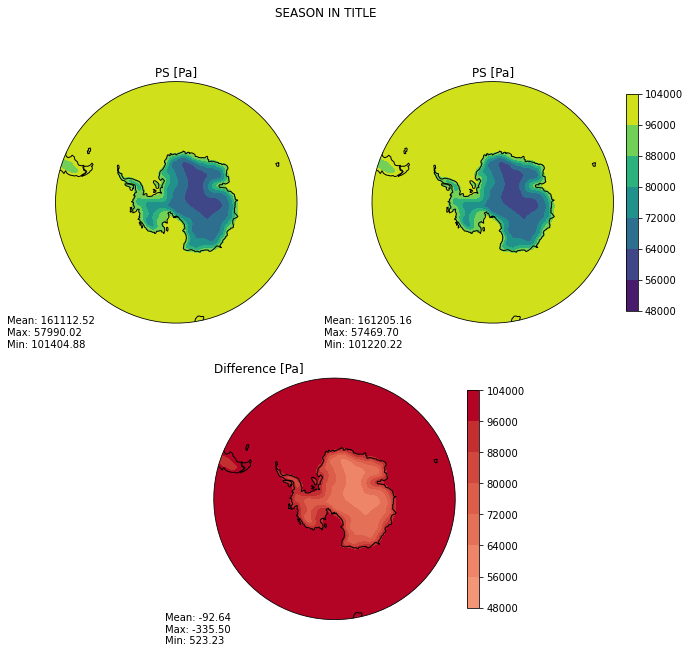

In [122]:

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.9)
ax1 = plt.subplot(gs[0, :2], projection=ccrs.SouthPolarStereo())
ax2 = plt.subplot(gs[0, 2:], projection=ccrs.SouthPolarStereo())
ax3 = plt.subplot(gs[1, 1:3], projection=ccrs.SouthPolarStereo())

img1 = ax1.contourf(lons, lats, cyclic_x, transform=ccrs.PlateCarree())
ax1.set_title(f"{x.name} [{x.units}]")
ax1.text(-0.2, -0.10, f"Mean: {x_region_mean:5.2f}\nMax: {x_region_max:5.2f}\nMin: {x_region_min:5.2f}", transform=ax1.transAxes)

img2 = ax2.contourf(lons, lats, cyclic_y, transform=ccrs.PlateCarree())
ax2.set_title(f"{y.name} [{y.units}]")
ax2.text(-0.2, -0.10, f"Mean: {y_region_mean:5.2f}\nMax: {y_region_max:5.2f}\nMin: {y_region_min:5.2f}", transform=ax2.transAxes)



img3 = ax3.contourf(lons, lats, cyclic_dif, transform=ccrs.PlateCarree(), cmap='coolwarm', norm=mpl.colors.TwoSlopeNorm(vmin=-100000, vcenter=0, vmax=100000))
ax3.set_title(f"Difference [{x.units}]", loc='left')
ax3.text(-0.2, -0.10, f"Mean: {dif_region_mean:5.2f}\nMax: {dif_region_max:5.2f}\nMin: {dif_region_min:5.2f}", transform=ax3.transAxes)


[a.set_extent(domain, ccrs.PlateCarree()) for a in [ax1, ax2, ax3]]
[a.coastlines() for a in [ax1, ax2, ax3]]

# Follow the cartopy gallery example to make circular:
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)

[a.set_boundary(circle, transform=a.transAxes) for a in [ax1, ax2, ax3]]

# COLORBARS
cb_mean_ax = inset_axes(ax2,
                   width="5%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.05, 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )
fig.colorbar(img1, cax=cb_mean_ax)

cb_diff_ax = inset_axes(ax3,
                   width="5%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.05, 1, 1),
                   bbox_transform=ax3.transAxes,
                   borderpad=0,
                   )
fig.colorbar(img3, cax=cb_diff_ax)
fig.suptitle("SEASON IN TITLE")